In [1]:
# Importing necessary libraries for data analysis and visualization

import json
from datetime import datetime

import matplotlib.pyplot as plt  # For creating various plots and visualizations
import numpy as np
import pandas as pd  # For handling and manipulating structured data (tables, CSV, etc.)
import seaborn as sns  # For advanced data visualization with statistical capabilities
# Importing automatic data profiling tool
import ydata_profiling as yd  # Used to generate a report with statistics, correlations, and distributions for data exploration
# Importing time series analysis tools from pandas and statsmodels
from pandas.plotting import \
    lag_plot  # For visualizing lag correlations in time series data
from statsmodels.graphics.tsaplots import (  # For plotting autocorrelation (ACF) and partial autocorrelation (PACF)
    plot_acf, plot_pacf)
# Importing seasonal decomposition tool for time series analysis
from statsmodels.tsa.seasonal import \
    seasonal_decompose  # To decompose a time series into trend, seasonality, and residual components
# Importing statistical test for stationarity
from statsmodels.tsa.stattools import \
    adfuller  # Augmented Dickey-Fuller (ADF) test to check stationarity of a time series

C:\Users\raedb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline


In [3]:
# Load the dataset
from pandas.api.types import is_datetime64_any_dtype


In [8]:
df = pd.read_csv(
    "datasets/train.csv",
    parse_dates=True,
)
# Try to detect a datetime column
for col in df.columns:
    df[col] = pd.to_datetime(
        df[col], errors="coerce"
    )  # Convert to datetime if possible
    if is_datetime64_any_dtype(df[col]):
        df.set_index(col, inplace=True)
        print(f"Set '{col}' as the datetime index.")
        break 
df

Set 'Date' as the datetime index.


,store,product,number_sold
Date,,,
2010-01-01,0,0,801
2010-01-02,0,0,810
2010-01-03,0,0,818
2010-01-04,0,0,796
2010-01-05,0,0,808
...,...,...,...
2018-12-27,6,9,890
2018-12-28,6,9,892
2018-12-29,6,9,895


In [9]:
DataProfile = yd.ProfileReport(df)
DataProfile.to_file("Profile.json")
DataProfile.to_file("Profile.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 120.75it/s]


In [10]:
# Basic exploration
print(df.head())
print(df.info())
print(df.describe())
df.dropna(inplace=True)

            store  product  number_sold
Date                                   
2010-01-01      0        0          801
2010-01-02      0        0          810
2010-01-03      0        0          818
2010-01-04      0        0          796
2010-01-05      0        0          808
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 230090 entries, 2010-01-01 to 2018-12-31
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   store        230090 non-null  int64
 1   product      230090 non-null  int64
 2   number_sold  230090 non-null  int64
dtypes: int64(3)
memory usage: 7.0 MB
None
               store        product    number_sold
count  230090.000000  230090.000000  230090.000000
mean        3.000000       4.500000     780.926107
std         2.000004       2.872288     204.096737
min         0.000000       0.000000     238.000000
25%         1.000000       2.000000     722.000000
50%         3.000000       4.500000     

In [11]:

def generate_mlops_report(df):
    """
    Generate a machine-interpretable EDA report for MLOps preprocessing
    
    Parameters:
    df (pandas.DataFrame): Input time series dataframe
    
    Returns:
    dict: Structured, machine-readable analysis report
    """
    report = {
        "dataset_metadata": {
            "total_columns": len(df.columns),
            "total_rows": len(df),
            "date_range": {
                "start": str(df.index.min()),
                "end": str(df.index.max())
            }
        },
        "preprocessing_recommendations": {
            "stationarity": {},
            "feature_scaling": [],
            "feature_engineering": []
        },
        "statistical_insights": {
            "descriptive_stats": {},
            "correlations": {
                "significant_correlations": [],
                "correlation_matrix": {}
            }
        }
    }
    
    # Stationarity Analysis
    for column in df.columns:
        adf_result = adfuller(df[column])
        report["preprocessing_recommendations"]["stationarity"][column] = {
            "is_stationary": str(adf_result[1] < 0.05),
            "p_value": float(adf_result[1]),
            "transformation_needed": "YES" if adf_result[1] >= 0.05 else "NO"
        }
        
        # Recommend transformations if not stationary
        if adf_result[1] >= 0.05:
            report["preprocessing_recommendations"]["feature_engineering"].append({
                "column": column,
                "suggested_transformations": [
                    "log_transformation",
                    "differencing",
                    "rolling_mean_normalization"
                ]
            })
    
    # Descriptive Statistics
    for column in df.columns:
        report["statistical_insights"]["descriptive_stats"][column] = {
            "mean": float(df[column].mean()),
            "std": float(df[column].std()),
            "min": float(df[column].min()),
            "max": float(df[column].max())
        }
    
    # Correlation Analysis
    corr_matrix = df.corr()
    report["statistical_insights"]["correlations"]["correlation_matrix"] = \
        {str(col): {str(subcol): float(corr_matrix.loc[col, subcol]) 
                    for subcol in df.columns} 
         for col in df.columns}
    
    # Significant Correlations
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 != col2:
                correlation = float(corr_matrix.loc[col1, col2])
                if abs(correlation) > 0.5:
                    report["statistical_insights"]["correlations"]["significant_correlations"].append({
                        "features": [col1, col2],
                        "correlation": correlation,
                        "strength": "strong" if abs(correlation) > 0.7 else "moderate"
                    })
    
    # Feature Scaling Recommendations
    for column in df.columns:
        if df[column].std() > 1:  # Suggest scaling for features with high variance
            report["preprocessing_recommendations"]["feature_scaling"].append({
                "column": column,
                "recommended_method": ["standardization", "min_max_scaling"]
            })
    
    return report

# Generate and save the report
final_report = generate_mlops_report(df)

# Save to JSON
with open('mlops_eda_report.json', 'w') as f:
    json.dump(final_report, f, indent=4)

print("MLOps-friendly EDA Report generated and saved to 'mlops_eda_report.json'")

MLOps-friendly EDA Report generated and saved to 'mlops_eda_report.json'


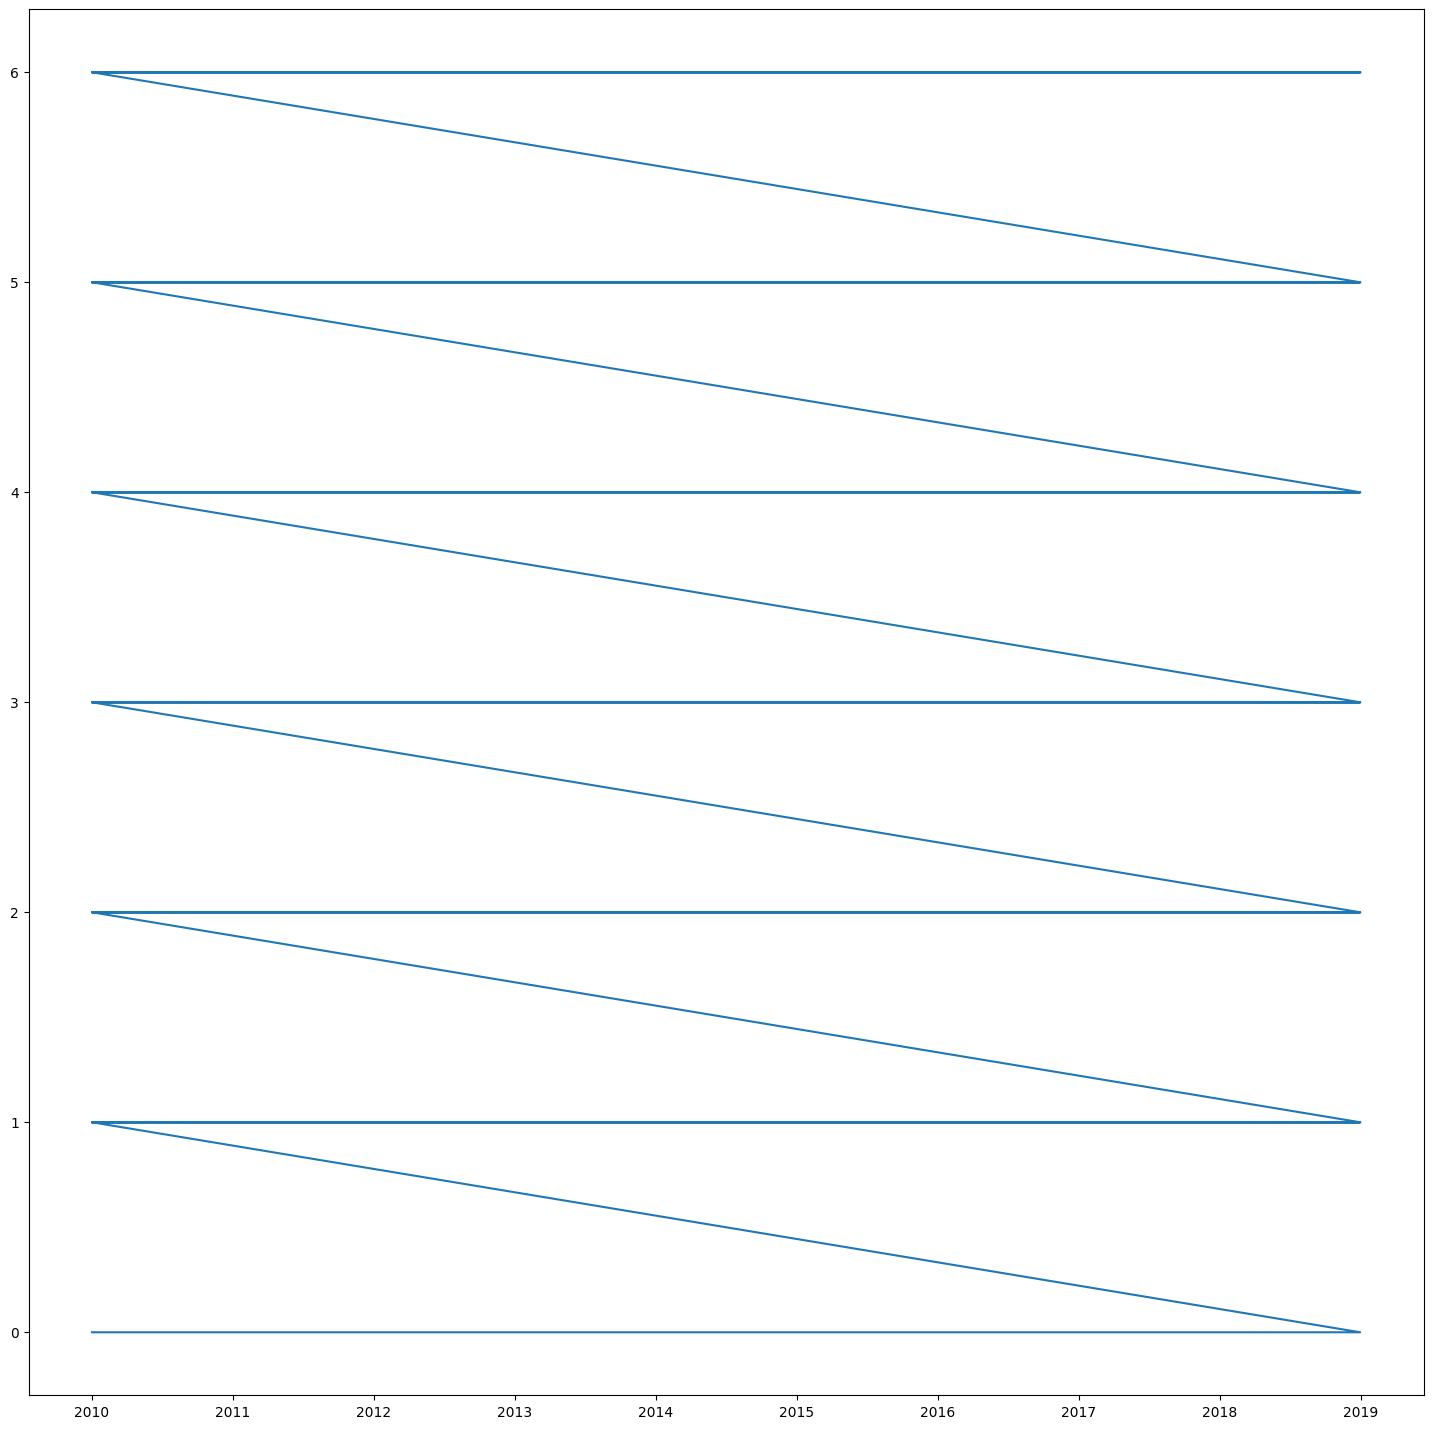

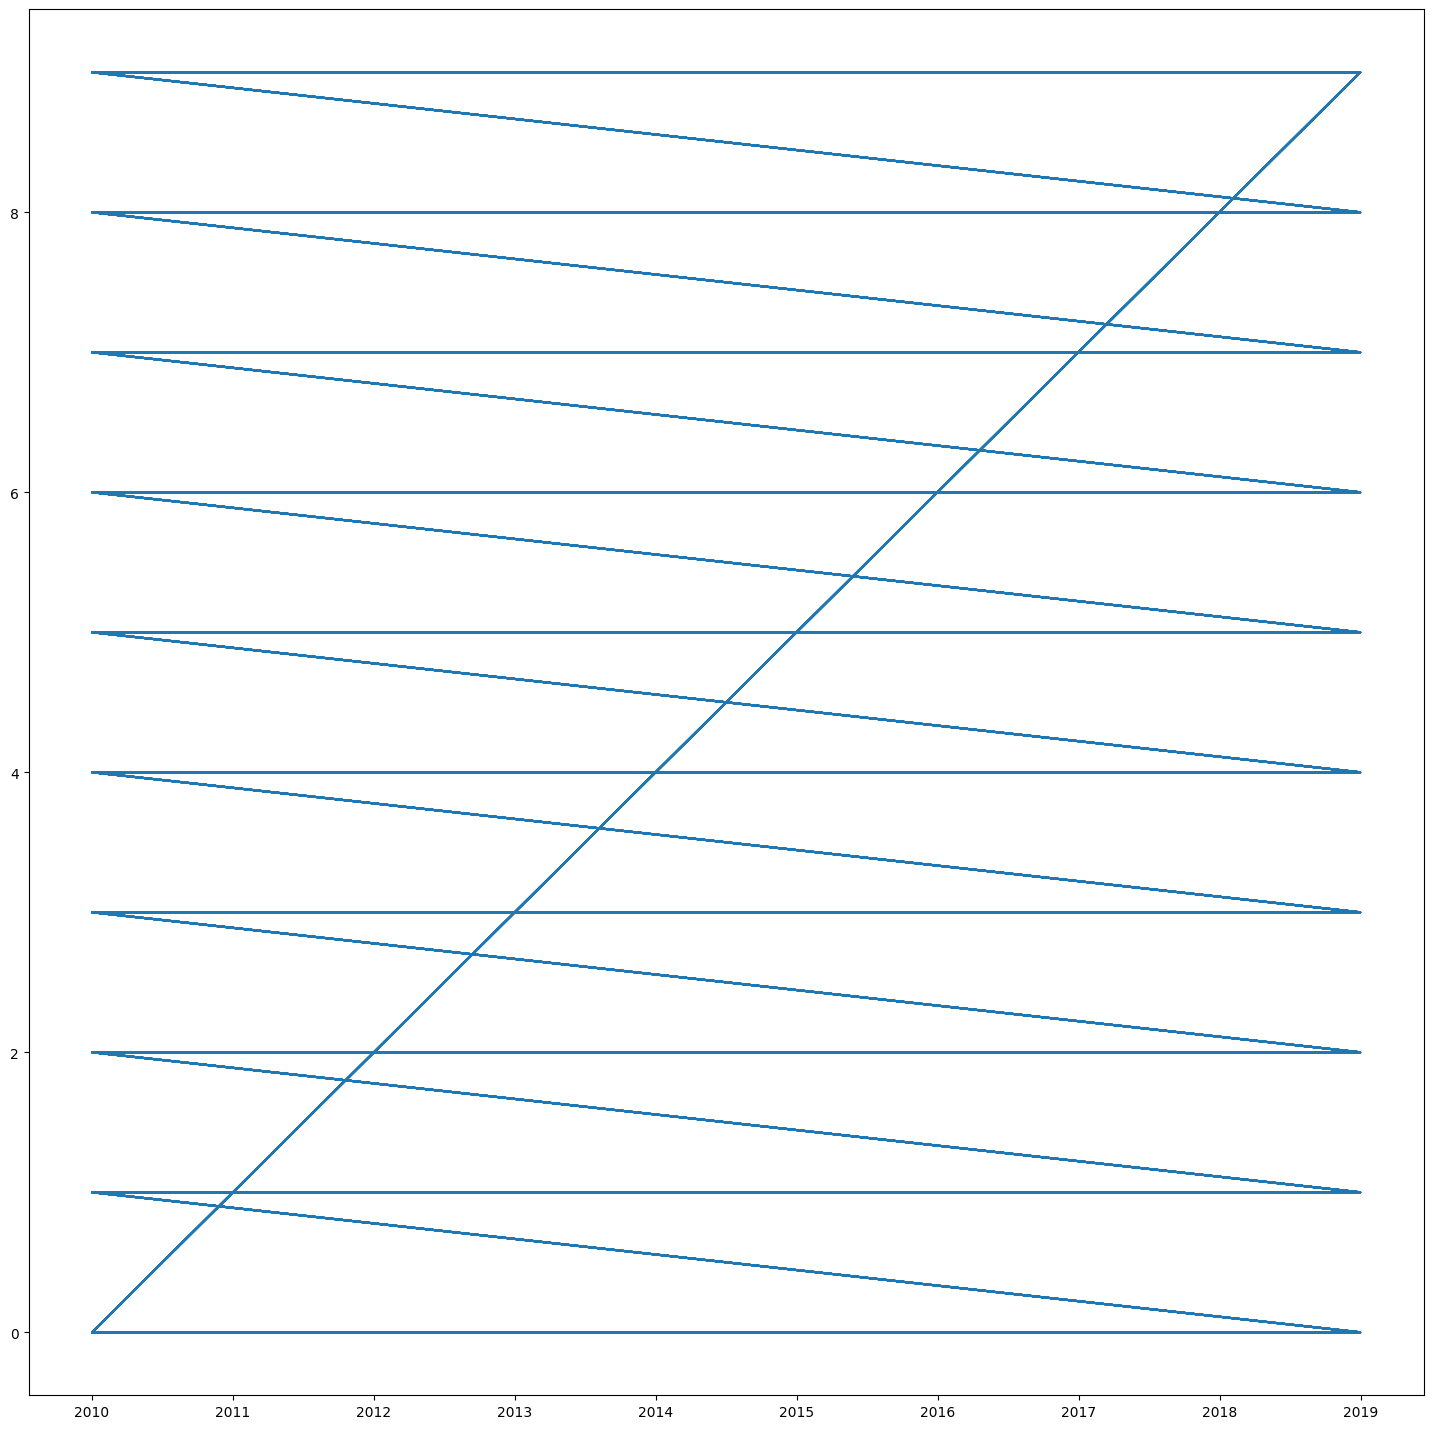

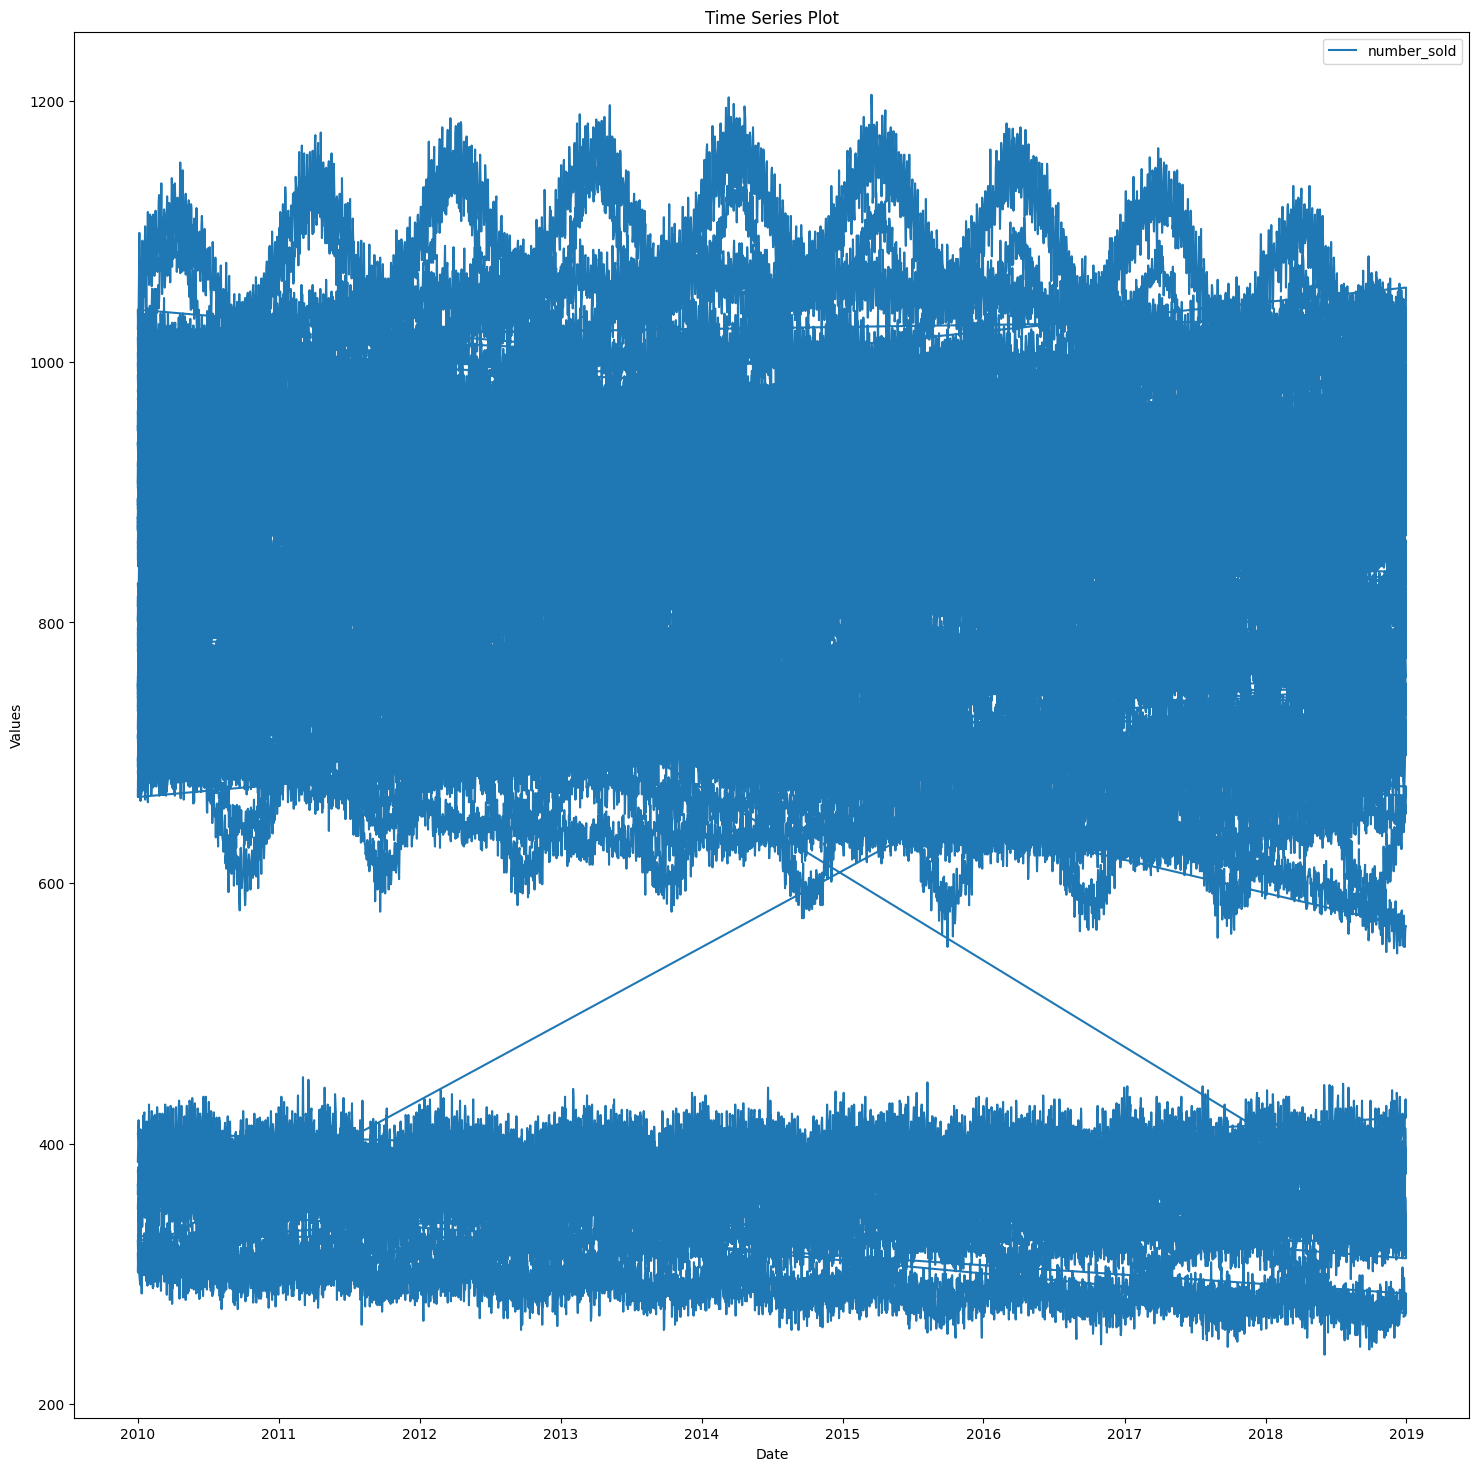

In [12]:
for column in df.columns:
    plt.figure(df.columns.get_loc(column)+1,figsize=(18, 18))
    # Plot the time series data for the current column
    plt.plot(df.index, df[column], label=column)
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()



Analyzing column: store
ADF Statistic for store: -0.6123639522472764
p-value for store: 0.8681637347706433


<Figure size 2000x1400 with 0 Axes>

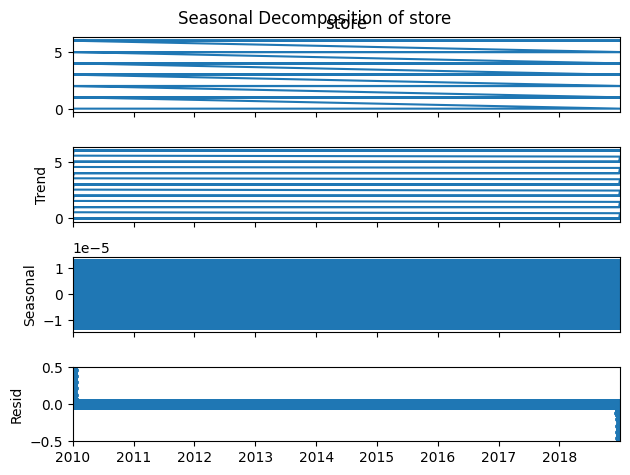


Analyzing column: product
ADF Statistic for product: -4.078911190131941
p-value for product: 0.0010492506930777606


<Figure size 2000x1400 with 0 Axes>

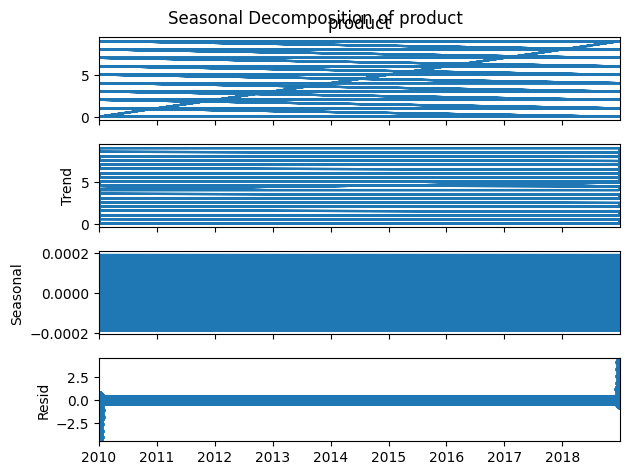


Analyzing column: number_sold
ADF Statistic for number_sold: -6.516349804844831
p-value for number_sold: 1.0689564216135569e-08


<Figure size 2000x1400 with 0 Axes>

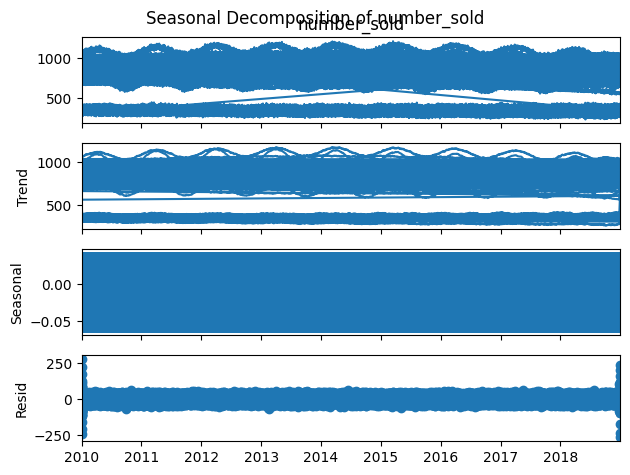

In [13]:

# Loop through each column in the DataFrame to perform stationarity testing and seasonal decomposition
for column in df.columns:
    print(f"\nAnalyzing column: {column}")  # Print the name of the column being analyzed
    
    # Create a new figure for the decomposition plot
    plt.figure(figsize=(20, 14))

    # --- Augmented Dickey-Fuller (ADF) Test for Stationarity ---
    adf_result = adfuller(df[column])  # Perform the ADF test on the current column
    print(f"ADF Statistic for {column}: {adf_result[0]}")  # Print the test statistic
    print(f"p-value for {column}: {adf_result[1]}")  # Print the p-value (to check stationarity)
    
    # The ADF test helps determine if a time series is stationary.
    # If p-value < 0.05, we reject the null hypothesis and conclude that the series is stationary.

    # --- Seasonal Decomposition ---
    # Decompose the time series into trend, seasonality, and residuals using an additive model
    decomposition = seasonal_decompose(df[column], model='additive', period=12)
    
    # Plot the decomposition results (observed, trend, seasonal, and residual components)
    decomposition.plot()
    
    # Set a title for the decomposition plot
    plt.suptitle(f'Seasonal Decomposition of {column}')
    
    # Display the plots
    plt.show()


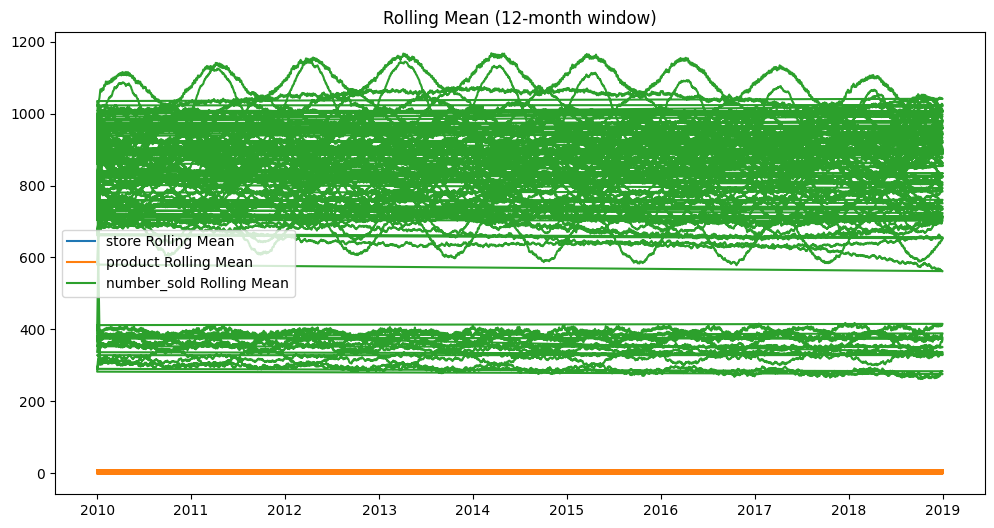

In [14]:
# Compute the rolling mean with a 12-month window for smoothing time series data
rolling_means = df.rolling(window=12).mean()

# Create a new figure with a specific size
plt.figure(figsize=(12, 6))

# Loop through each column in the DataFrame to plot its rolling mean
for column in df.columns:
    plt.plot(rolling_means.index, rolling_means[column], label=f'{column} Rolling Mean')

# Set the title of the plot
plt.title('Rolling Mean (12-month window)')

# Add a legend to indicate which rolling mean corresponds to which column
plt.legend()

# Display the plot
plt.show()



Correlation Matrix:
                    store       product  number_sold
store        1.000000e+00  6.692764e-15     0.201994
product      6.692764e-15  1.000000e+00     0.033124
number_sold  2.019938e-01  3.312389e-02     1.000000


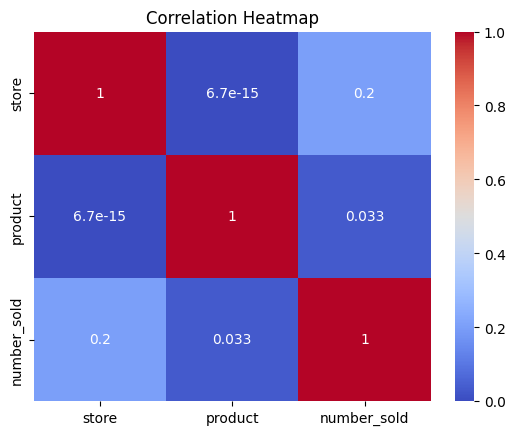

In [15]:
# Compute the correlation matrix for all numerical columns in the DataFrame
df_corr = df.corr()

# Print the correlation matrix to inspect the numerical relationships between variables
print("Correlation Matrix:")
print(df_corr)

# Create a heatmap to visualize the correlation matrix
sns.heatmap(df_corr, annot=True, cmap='coolwarm')

# Set the title for the heatmap
plt.title('Correlation Heatmap')

# Display the heatmap
plt.show()



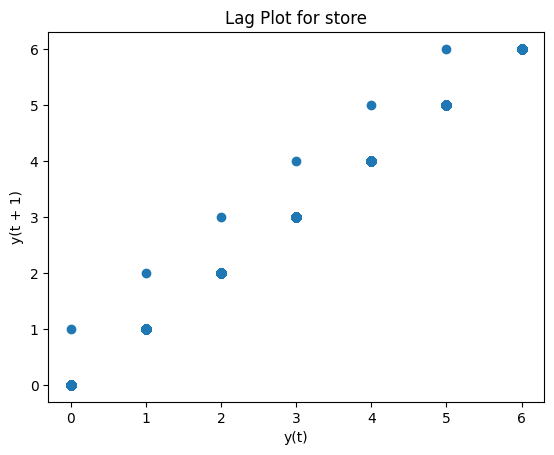

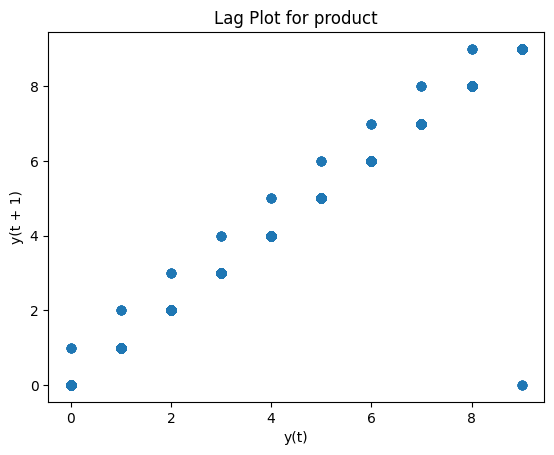

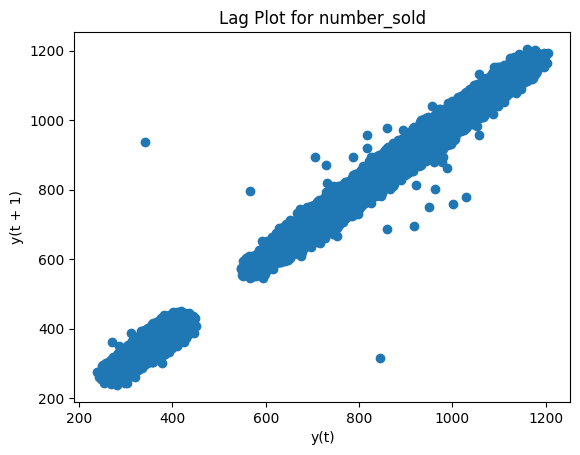

In [16]:
for column in df.columns:
    plt.figure()
    lag_plot(df[column])
    plt.title(f'Lag Plot for {column}')
    plt.show()


Autocorrelation and Partial Autocorrelation for store


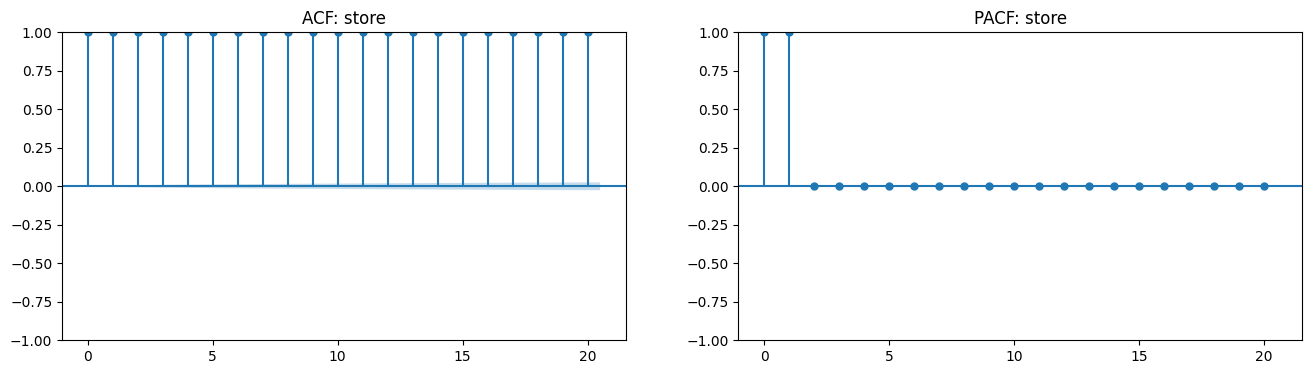

Autocorrelation and Partial Autocorrelation for product


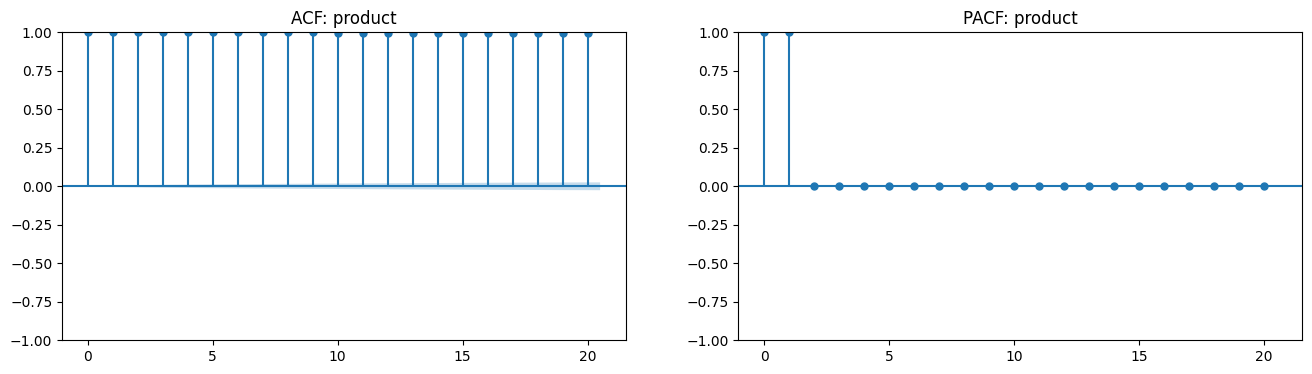

Autocorrelation and Partial Autocorrelation for number_sold


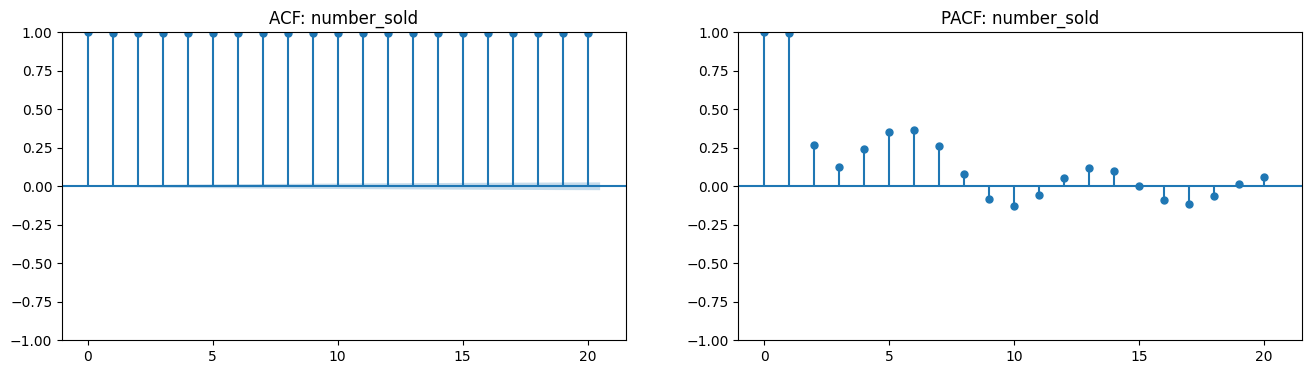

In [17]:
for column in df.columns:
    print(f"Autocorrelation and Partial Autocorrelation for {column}")
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    plot_acf(df[column], ax=axes[0], lags=20, title=f'ACF: {column}')
    plot_pacf(df[column], ax=axes[1], lags=20, title=f'PACF: {column}')
    plt.show()

In [18]:
# Create a new DataFrame with lagged versions of the original columns
lagged_df = pd.concat(
    [df.shift(i).add_suffix(f"_lag{i}") for i in range(1, 4)], axis=1  # Lag 1, 2, 3
)

# Concatenate the original DataFrame with the lagged features and remove any NaN values
lagged_df = pd.concat([df, lagged_df], axis=1).dropna()

# Display the first few rows of the new DataFrame with lagged values
print(lagged_df.head())


            store  product  number_sold  store_lag1  product_lag1  \
Date                                                                
2010-01-04      0        0          796         0.0           0.0   
2010-01-05      0        0          808         0.0           0.0   
2010-01-06      0        0          812         0.0           0.0   
2010-01-07      0        0          830         0.0           0.0   
2010-01-08      0        0          812         0.0           0.0   

            number_sold_lag1  store_lag2  product_lag2  number_sold_lag2  \
Date                                                                       
2010-01-04             818.0         0.0           0.0             810.0   
2010-01-05             796.0         0.0           0.0             818.0   
2010-01-06             808.0         0.0           0.0             796.0   
2010-01-07             812.0         0.0           0.0             808.0   
2010-01-08             830.0         0.0           0.0      

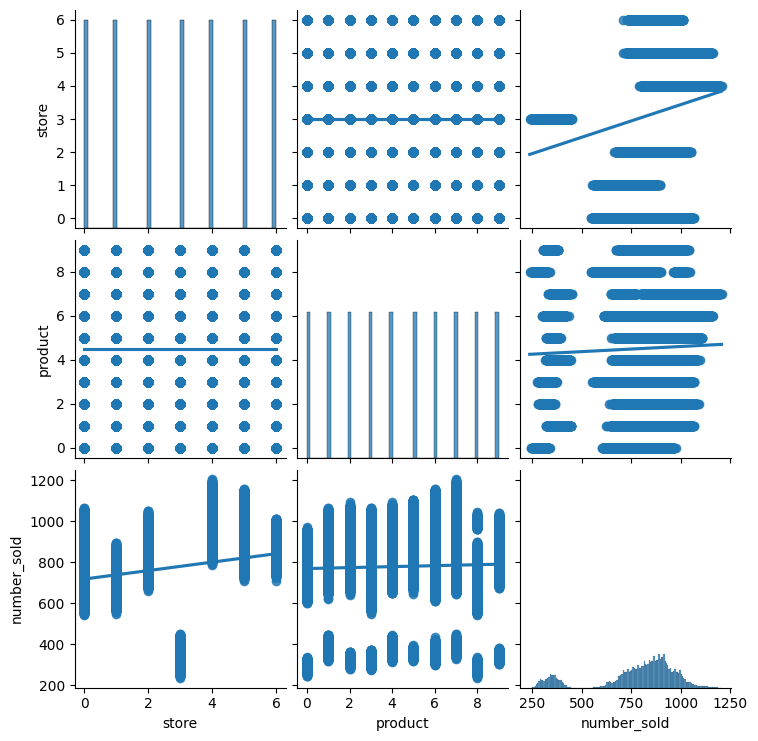

In [19]:
# Create pairwise scatter plots for all numerical columns in the DataFrame
sns.pairplot(df, kind="reg")

plt.show()